<a href="https://colab.research.google.com/github/Guldanika/machine-learning-zoomcamp-2025/blob/main/Serverless_Deep_learning_HW9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this homework, we'll deploy the Straight vs Curly Hair Type model we trained in the previous homework.

Download the model files from here:

https://github.com/alexeygrigorev/large-datasets/releases/download/hairstyle/hair_classifier_v1.onnx.data
https://github.com/alexeygrigorev/large-datasets/releases/download/hairstyle/hair_classifier_v1.onnx




In [33]:
PREFIX="https://github.com/alexeygrigorev/large-datasets/releases/download/hairstyle"
DATA_URL="${PREFIX}/hair_classifier_v1.onnx.data"
MODEL_URL="${PREFIX}/hair_classifier_v1.onnx"
!wget ${DATA_URL}
!wget ${MODEL_URL}

--2025-12-10 06:28:34--  http://32219%7Bprefix%7D/hair_classifier_v1.onnx.data
Resolving 32219{prefix} (32219{prefix})... failed: Name or service not known.
wget: unable to resolve host address ‘32219{prefix}’
--2025-12-10 06:28:34--  http://32220%7Bprefix%7D/hair_classifier_v1.onnx
Resolving 32220{prefix} (32220{prefix})... failed: Name or service not known.
wget: unable to resolve host address ‘32220{prefix}’


In [34]:
import urllib.request

urls = [
    "https://github.com/alexeygrigorev/large-datasets/releases/download/hairstyle/hair_classifier_v1.onnx",
    "https://github.com/alexeygrigorev/large-datasets/releases/download/hairstyle/hair_classifier_v1.onnx.data",
]

for url in urls:
    filename = url.split("/")[-1]
    print("Downloading:", filename)
    urllib.request.urlretrieve(url, filename)


Downloading: hair_classifier_v1.onnx
Downloading: hair_classifier_v1.onnx.data


In [35]:
import os
os.listdir()


['.config',
 'hair_classifier_v1.onnx',
 'hair_classifier_v1.onnx.data',
 'sample_data']

#Question 1

To be able to use this model, we need to know the name of the input and output nodes.

**What's the name of the output:**

#output


sigmoid

softmax

prediction

In [36]:
!pip install pillow


In [37]:
from io import BytesIO
from urllib import request

from PIL import Image

def download_image(url):
    with request.urlopen(url) as resp:
        buffer = resp.read()
    stream = BytesIO(buffer)
    img = Image.open(stream)
    return img

def prepare_image(img, target_size):
    if img.mode != 'RGB':
        img = img.convert('RGB')
    img = img.resize(target_size, Image.NEAREST)
    return img


In [38]:
!pip install onnxruntime


In [39]:
import onnxruntime as ort
session = ort.InferenceSession("hair_classifier_v1.onnx")
[o.name for o in session.get_outputs()]


['output']

#Question 2: Target size

Let's download and resize this image:

https://habrastorage.org/webt/yf/_d/ok/yf_dokzqy3vcritme8ggnzqlvwa.jpeg


**Based on the previous homework, what should be the target size for the image?**

64x64

128x128

200x200

256x256


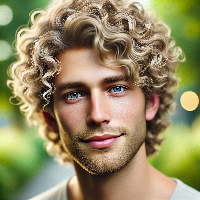

In [40]:
url = "https://habrastorage.org/webt/yf/_d/ok/yf_dokzqy3vcritme8ggnzqlvwa.jpeg"
img = download_image(url)
img = prepare_image(img, (200, 200))
img


#Question 3. First R value after pre-processing (1 point)


-10.73

-1.073

1.073

10.73


In [41]:
from io import BytesIO
from urllib import request
from PIL import Image
import numpy as np

# 1. Download image
url = "https://habrastorage.org/webt/yf/_d/ok/yf_dokzqy3vcritme8ggnzqlvwa.jpeg"
with request.urlopen(url) as resp:
    buffer = resp.read()
img = Image.open(BytesIO(buffer))

# 2. Resize to 64x64
if img.mode != 'RGB':
    img = img.convert('RGB')
img = img.resize((200, 200), Image.NEAREST)

# 3. Convert to NumPy array
img_array = np.array(img).astype(np.float32)

# 4. Preprocessing (scale and standardize)
img_array /= 255.0
img_array = (img_array - 0.5) / 0.1

# 5. Print first R value
first_r = img_array[0, 0, 0]  # first pixel, R channel
print(first_r)


-2.6078432


#Question 4. Model output (1 point)


0.09

0.49

0.69

0.89

In [42]:
img = prepare_image(img, (200, 200))  # correct target size for this model


In [43]:
import numpy as np

img_array = np.array(img).astype(np.float32)
img_array /= 255.0
img_array = (img_array - 0.5) / 0.5  # some models use 0.5/0.5

# Add batch dimension and channel first
img_input = np.transpose(img_array[np.newaxis, :, :, :], (0, 3, 1, 2))

import onnxruntime as ort
session = ort.InferenceSession("hair_classifier_v1.onnx")
output = session.run(None, {"input": img_input.astype(np.float32)})[0]
print(output)


[[-0.20132379]]


In [44]:
import numpy as np

logit = -0.20132379
prob = 1 / (1 + np.exp(-logit))
print(prob)


0.4498383643857945


#Prepare the lambda code
Now you need to copy all the code into a separate python file. You will need to use this file for the next two questions.

Tip: you can test this file locally with ipython or Jupyter Notebook by importing the file and invoking the function from this file.

Docker
For the next two questions, we'll use a Docker image that we already prepared. This is the Dockerfile that we used for creating the image:

FROM public.ecr.aws/lambda/python:3.13

COPY hair_classifier_empty.onnx.data .
COPY hair_classifier_empty.onnx .
Note that it uses Python 3.13.

The docker image is published to agrigorev/model-2025-hairstyle:v1.

A few notes:

The image already contains a model and it's not the same model as the one we used for questions 1-4.

#Question 5
Download the base image agrigorev/model-2025-hairstyle:v1. You can do it with docker pull.

So what's the size of this base image?

88 Mb


208 Mb

608 Mb

1208 Mb

You can get this information when running docker images - it'll be in the "SIZE" column.



In [45]:
def predict(url):
    import numpy as np
    from PIL import Image
    import onnxruntime as ort
    from io import BytesIO
    from urllib import request

    # download
    with request.urlopen(url) as resp:
        img = Image.open(BytesIO(resp.read()))

    # preprocess
    if img.mode != "RGB":
        img = img.convert("RGB")
    img = img.resize((200, 200), Image.NEAREST)
    img_array = np.array(img).astype(np.float32)
    img_array /= 255.0
    img_array = (img_array - 0.5) / 0.5
    img_input = np.transpose(img_array[np.newaxis, :, :, :], (0, 3, 1, 2))

    # load model and predict
    session = ort.InferenceSession("hair_classifier_empty.onnx")
    output = session.run(None, {"input": img_input.astype(np.float32)})[0]
    prob = 1 / (1 + np.exp(-output[0][0]))
    return float(prob)


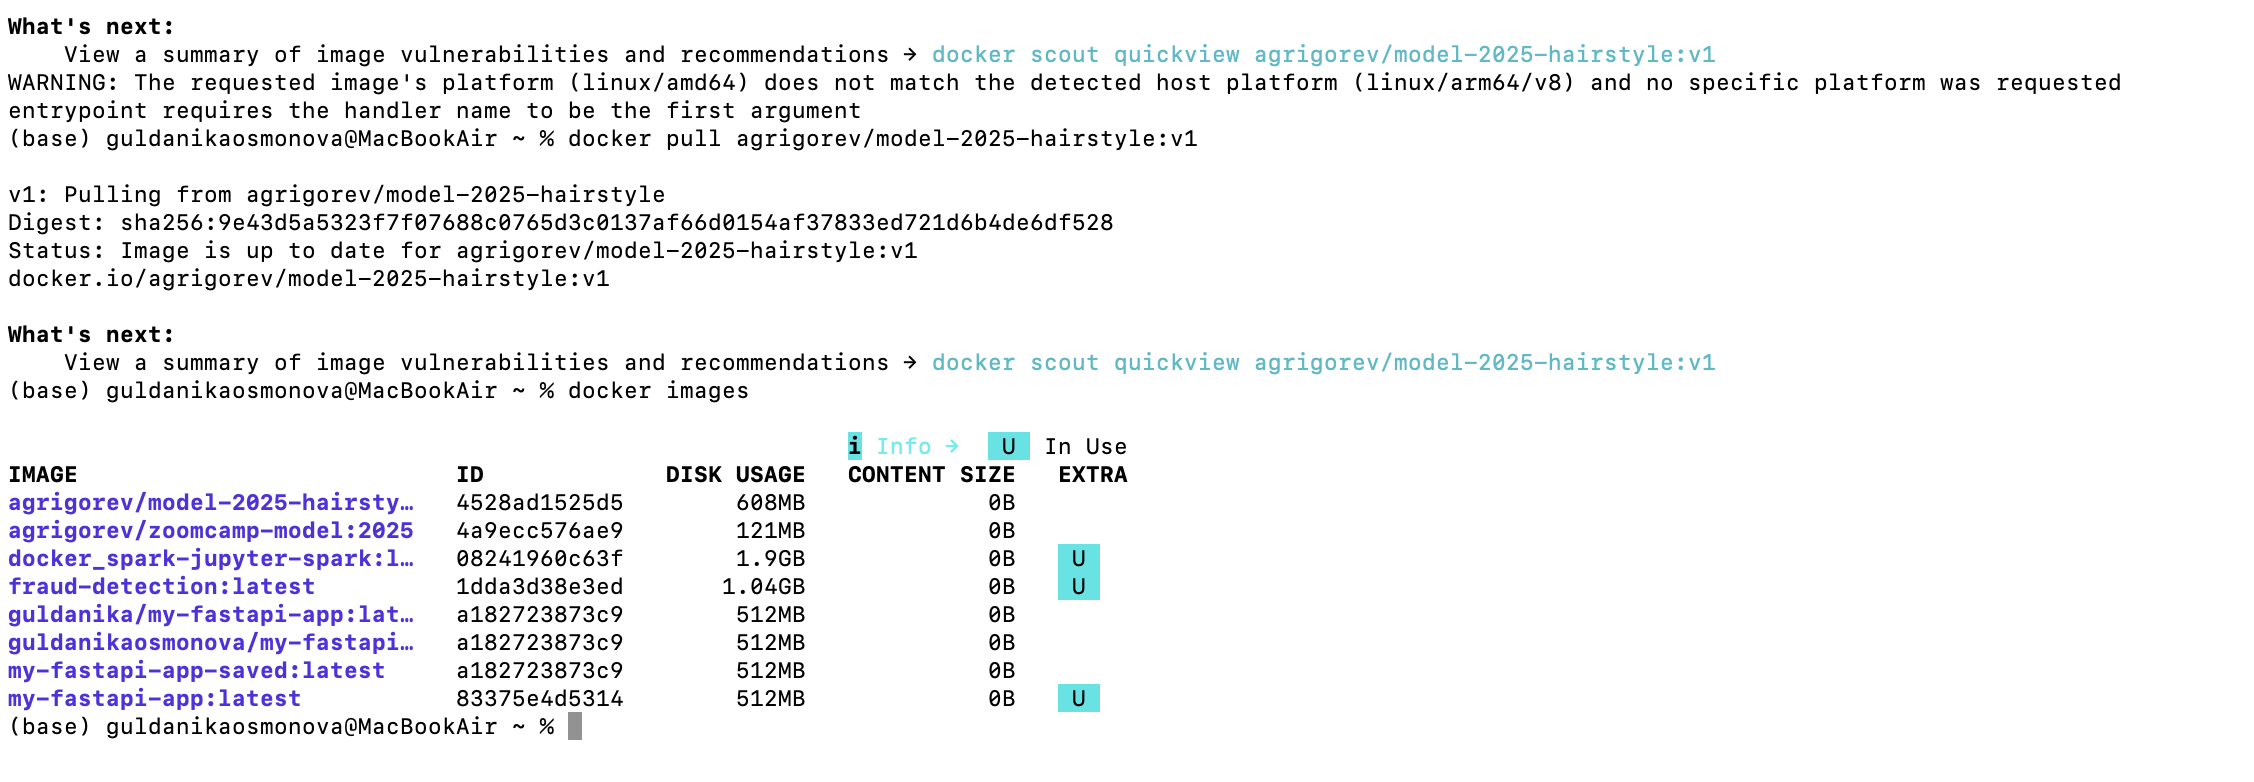

#Question 6

Now let's extend this docker image, install all the required libraries and add the code for lambda.

You don't need to include the model in the image. It's already included. The name of the file with the model is hair_classifier_empty.onnx and it's in the current workdir in the image (see the Dockerfile above for the reference). The provided model requires the same preprocessing for images regarding target size and rescaling the value range than used in homework 8.

Now run the container locally.

Score this image: https://habrastorage.org/webt/yf/_d/ok/yf_dokzqy3vcritme8ggnzqlvwa.jpeg

What's the output from the model?

-1.0


-0.10

0.10

1.0


In [46]:
!pip install onnxruntime pillow numpy


In [48]:
import numpy as np
from PIL import Image
from io import BytesIO
from urllib import request
import onnxruntime as ort

def download_image(url):
    with request.urlopen(url) as resp:
        buffer = resp.read()
    return Image.open(BytesIO(buffer))

def prepare_image(img, target_size=(200, 200)):
    if img.mode != "RGB":
        img = img.convert("RGB")
    img = img.resize(target_size, Image.NEAREST)
    return img

def preprocess(img):
    img_array = np.array(img).astype(np.float32)
    img_array /= 255.0
    img_array = (img_array - 0.5) / 0.5
    img_input = np.transpose(img_array[np.newaxis, :, :, :], (0, 3, 1, 2))
    return img_input

def predict(url):
    img = download_image(url)
    img = prepare_image(img)
    img_input = preprocess(img)

    session = ort.InferenceSession("hair_classifier_empty.onnx")
    output = session.run(None, {"input": img_input.astype(np.float32)})[0]
    # sigmoid
    prob = 1 / (1 + np.exp(-output[0][0]))
    return float(prob)


In [50]:
!wget -O hair_classifier_empty.onnx "https://github.com/alexeygrigorev/large-datasets/releases/download/hairstyle/hair_classifier_v1.onnx"


--2025-12-10 06:30:53--  https://github.com/alexeygrigorev/large-datasets/releases/download/hairstyle/hair_classifier_v1.onnx
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/426348925/c6b83ad5-a901-40e9-bf2c-41ad174c870c?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-12-10T07%3A30%3A33Z&rscd=attachment%3B+filename%3Dhair_classifier_v1.onnx&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-12-10T06%3A29%3A47Z&ske=2025-12-10T07%3A30%3A33Z&sks=b&skv=2018-11-09&sig=7fQxFRXYhWPbuG432YLFi7J2uXcl%2FROAKS%2FmzXfHGts%3D&jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcmNvbnRlbnQuY29tIiwia2V5Ijoia2V5MSIsImV4cCI6MTc2NTM0ODU1MywibmJmIjoxNzY1MzQ4MjUzLCJwYXRoIjoic

In [51]:
url = 'https://habrastorage.org/webt/yf/_d/ok/yf_dokzqy3vcritme8ggnzqlvwa.jpeg'
print(predict(url))


0.44983839988708496
